In [33]:
import scipy.io as sio

# Load the data from the MATLAB file
data = sio.loadmat('KukaDirectDynamics.mat')

In [34]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Feb 26 16:53:29 2016',
 '__version__': '1.0',
 '__globals__': [],
 'kukatraj1': array([[ 0.26213163,  0.24401024, -0.34289578, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.26213163,  0.24401024, -0.34289578, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.26213163,  0.24401024, -0.34289578, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.26203451,  0.24401152, -0.34299672, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.26203451,  0.24401152, -0.34299672, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.26203451,  0.24401152, -0.34299672, ...,  0.        ,
          0.        ,  0.        ]]),
 'kukatraj10': array([[ 2.62187928e-01,  2.44056255e-01, -3.42939198e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.62187928e-01,  2.44056255e-01, -3.42939198e-01, ...,
          0.0000

In [35]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [36]:
# Assuming 'kukatraj1', 'kukatraj2', etc. are the trajectory keys
trajectories = [data[key] for key in data.keys() if key.startswith('kukatraj')]

# Randomly shuffle the trajectories
np.random.shuffle(trajectories)

# Determine the maximum trajectory length
max_length = max(len(traj) for traj in trajectories)

# Pad the trajectories with zeros to match the maximum length
padded_trajectories = [np.pad(traj, ((0, max_length - len(traj)), (0, 0)), 'constant') for traj in trajectories]

# Convert trajectory data to PyTorch tensors
inputs = torch.tensor([traj[:, :21] for traj in padded_trajectories], dtype=torch.float32)
targets = torch.tensor([traj[:, 21:] for traj in padded_trajectories], dtype=torch.float32)

# Print out the lengths of the trajectories for diagnosis
lengths = [len(traj) for traj in padded_trajectories]
print("Trajectory Lengths:", lengths)

# Determine the split ratio (e.g., 80% for training, 20% for validation)
train_ratio = 0.8
num_trajectories = len(padded_trajectories)
num_train = int(train_ratio * num_trajectories)
num_valid = num_trajectories - num_train

# Split into training and validation sets
train_inputs, valid_inputs = inputs[:num_train], inputs[num_train:]
train_targets, valid_targets = targets[:num_train], targets[num_train:]

Trajectory Lengths: [2509, 2509, 2509, 2509, 2509, 2509, 2509, 2509, 2509, 2509]


In [37]:
# Define Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

In [38]:
# Instantiate Custom Dataset objects for training and validation
train_dataset = CustomDataset(train_inputs, train_targets)
valid_dataset = CustomDataset(valid_inputs, valid_targets)

# Create Custom DataLoader for training and validation
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [39]:
import torch.nn as nn

class DeterministicModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeterministicModel, self).__init__()
        # Define your architecture here
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
class GaussianModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GaussianModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.mean_fc = nn.Linear(128, output_dim)
        self.std_fc = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean_fc(x)
        std = torch.exp(self.std_fc(x))  # Ensure standard deviation is positive
        return mean, std

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

In [42]:
# Initialize the deterministic model
input_dim = 21  # Adjust according to dataset
output_dim = 14  # Adjust according to  dataset
deterministic_model = DeterministicModel(input_dim, output_dim)

In [43]:
import torch.optim as optim
num_epochs = 50
train_losses = []
valid_losses = []

#Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
deterministic_optimizer = optim.Adam(deterministic_model.parameters(), lr=0.001)

In [44]:
for epoch in range(num_epochs):
    # Training
    deterministic_model.train()
    total_train_loss = 0.0
    for inputs, targets in train_loader:
        deterministic_optimizer.zero_grad()
        outputs = deterministic_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        deterministic_optimizer.step()
        total_train_loss += loss.item() * len(inputs)
    train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    deterministic_model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = deterministic_model(inputs)
            loss = criterion(outputs, targets)
            total_valid_loss += loss.item() * len(inputs)
    valid_loss = total_valid_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    # Print the training and validation losses at each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

Epoch [1/50] - Train Loss: 0.8364, Validation Loss: 0.4017
Epoch [2/50] - Train Loss: 0.4386, Validation Loss: 0.2103
Epoch [3/50] - Train Loss: 0.2330, Validation Loss: 0.1638
Epoch [4/50] - Train Loss: 0.1757, Validation Loss: 0.1896
Epoch [5/50] - Train Loss: 0.1951, Validation Loss: 0.2145
Epoch [6/50] - Train Loss: 0.2178, Validation Loss: 0.2087
Epoch [7/50] - Train Loss: 0.2122, Validation Loss: 0.1771
Epoch [8/50] - Train Loss: 0.1820, Validation Loss: 0.1363
Epoch [9/50] - Train Loss: 0.1426, Validation Loss: 0.1002
Epoch [10/50] - Train Loss: 0.1080, Validation Loss: 0.0743
Epoch [11/50] - Train Loss: 0.0834, Validation Loss: 0.0582
Epoch [12/50] - Train Loss: 0.0686, Validation Loss: 0.0500
Epoch [13/50] - Train Loss: 0.0615, Validation Loss: 0.0469
Epoch [14/50] - Train Loss: 0.0592, Validation Loss: 0.0463
Epoch [15/50] - Train Loss: 0.0594, Validation Loss: 0.0462
Epoch [16/50] - Train Loss: 0.0595, Validation Loss: 0.0452
Epoch [17/50] - Train Loss: 0.0582, Validation Lo

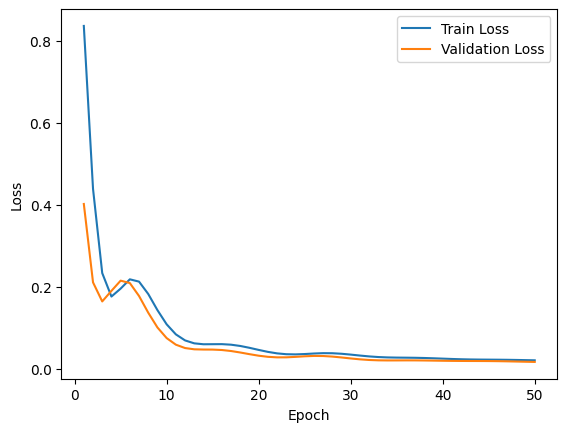

In [45]:
# Plot the learning progress
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
# Initialize the Gaussian model
gaussian_model = GaussianModel(input_dim, output_dim)

# Define the optimizer for Gaussian model
gaussian_optimizer = optim.Adam(gaussian_model.parameters(), lr=0.001)

# Define the loss function for Gaussian model
def gaussian_loss(prediction, target, std):
    mse_loss = torch.mean((prediction - target)**2)
    std_loss = torch.mean(torch.log(std)**2)  # Regularization term for std
    return mse_loss + std_loss

def train_gaussian(model, optimizer, dataloader):
    model.train()
    total_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        mean, std = model(inputs)
        loss = gaussian_loss(mean, targets, std)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(inputs)
    return total_loss / len(dataloader.dataset)

def validate_gaussian(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            mean, std = model(inputs)
            loss = gaussian_loss(mean, targets, std)
            total_loss += loss.item() * len(inputs)
    return total_loss / len(dataloader.dataset)

In [47]:
num_epochs = 50
train_loss_gaussian = []
valid_loss_gaussian = []
for epoch in range(num_epochs):
    train_loss = train_gaussian(gaussian_model, gaussian_optimizer, train_loader)
    valid_loss = validate_gaussian(gaussian_model, valid_loader)
    train_loss_gaussian.append(train_loss)
    valid_loss_gaussian.append(valid_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

Epoch [1/50] - Train Loss: 1.1040, Validation Loss: 0.6108
Epoch [2/50] - Train Loss: 0.6590, Validation Loss: 0.3660
Epoch [3/50] - Train Loss: 0.4118, Validation Loss: 0.2472
Epoch [4/50] - Train Loss: 0.2887, Validation Loss: 0.1931
Epoch [5/50] - Train Loss: 0.2293, Validation Loss: 0.1666
Epoch [6/50] - Train Loss: 0.1974, Validation Loss: 0.1510
Epoch [7/50] - Train Loss: 0.1769, Validation Loss: 0.1395
Epoch [8/50] - Train Loss: 0.1612, Validation Loss: 0.1312
Epoch [9/50] - Train Loss: 0.1494, Validation Loss: 0.1261
Epoch [10/50] - Train Loss: 0.1410, Validation Loss: 0.1227
Epoch [11/50] - Train Loss: 0.1353, Validation Loss: 0.1185
Epoch [12/50] - Train Loss: 0.1293, Validation Loss: 0.1100
Epoch [13/50] - Train Loss: 0.1198, Validation Loss: 0.0971
Epoch [14/50] - Train Loss: 0.1067, Validation Loss: 0.0819
Epoch [15/50] - Train Loss: 0.0917, Validation Loss: 0.0679
Epoch [16/50] - Train Loss: 0.0779, Validation Loss: 0.0572
Epoch [17/50] - Train Loss: 0.0674, Validation Lo

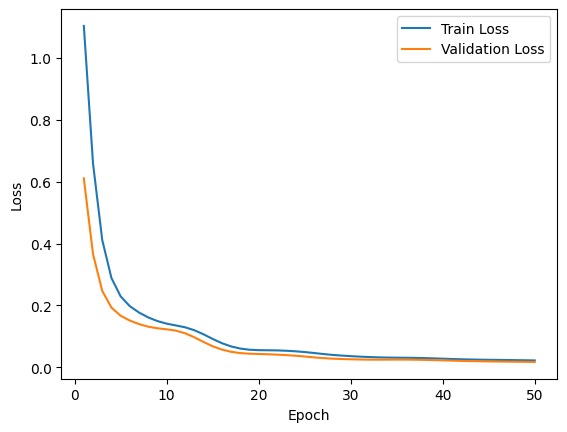

In [48]:
# Plot the learning progress
plt.plot(range(1, num_epochs + 1), train_loss_gaussian, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss_gaussian, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
import scipy.stats as stats

def evaluate_gaussian_model(model, dataloader):
    model.eval()
    predicted_means = []
    predicted_stds = []
    ground_truth = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            mean, std = model(inputs)
            predicted_means.append(mean)
            predicted_stds.append(std)
            ground_truth.append(targets)

    predicted_means = torch.cat(predicted_means, dim=0)
    predicted_stds = torch.cat(predicted_stds, dim=0)
    ground_truth = torch.cat(ground_truth, dim=0)

    # Calculate the p-values for each predicted sample
    p_values = stats.norm.cdf(ground_truth.cpu().numpy(), loc=predicted_means.cpu().numpy(), scale=predicted_stds.cpu().numpy())

    # Calculate the mean p-value across all samples and dimensions
    mean_p_value = torch.mean(torch.tensor(p_values))

    return mean_p_value

In [50]:
# Evaluate the Gaussian model on the validation set
mean_p_value = evaluate_gaussian_model(gaussian_model, valid_loader)
print(f"Mean P-Value: {mean_p_value.item()}")

Mean P-Value: 0.5008494711933307


In [51]:
def evaluate_deterministic_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            all_predictions.extend(outputs.numpy())
            all_targets.extend(targets.numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Calculate the mean squared error (MSE)
    mse = ((all_predictions - all_targets) ** 2).mean()

    # Calculate the p-value using the t-test
    _, p_value = stats.ttest_rel(all_predictions, all_targets)

    # Convert the p-value array to a scalar value (e.g., by taking the mean)
    p_value_scalar = np.mean(p_value)

    return mse, p_value_scalar

# Evaluate the deterministic model on the validation set
deterministic_mse, deterministic_p_value = evaluate_deterministic_model(deterministic_model, valid_loader)

print("Deterministic Model:")
print(f"Mean Squared Error (MSE): {deterministic_mse:.4f}")
print(f"P-value: {deterministic_p_value:.4f}")

Deterministic Model:
Mean Squared Error (MSE): 0.0161
P-value: 0.2400
